In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BDM - ML") \
    .getOrCreate()

In [11]:
df = spark.read.format("jdbc").option("url", "jdbc:postgresql://clefable.fib.upc.edu:9700/bdm") \
    .option("driver", "org.postgresql.Driver").option("dbtable", "agricultural_exports_agg_full") \
    .option("user", "postgres").option("password", "postgres").load()

In [442]:
# A CSV with the same data of the database is provided in case the code has to be run and the database is not available
# This CSV is an exact copy of the Materialized View mentioned in the report, but only with data from Brazil
df = spark.read.option("header", "true").csv("./bdm_public_agricultural_exports_agg_full.csv")

In [501]:
df.orderBy(["category", col("month").desc()]).show(4)

+-------+--------+------------------+------+
|  month|category|       total_price|origin|
+-------+--------+------------------+------+
|2022-05|    0600|  39048.9429833889|   BRA|
|2022-04|    0600|311423.95265356824|   BRA|
|2022-03|    0600| 87.54999852180481|   BRA|
|2022-02|    0600|                 0|   BRA|
+-------+--------+------------------+------+
only showing top 4 rows



In [444]:
df.createOrReplaceTempView("exports")

In [502]:
cat_df = spark.sql("SELECT category as cat, month as ds, total_price as y FROM exports WHERE month > '2018' AND origin = 'BRA' ORDER BY cat, month")

In [446]:
pdf = cat_df.toPandas()
pdf.head()

,cat,ds,y
0,0600,2018-01,0
1,0600,2018-02,0
2,0600,2018-03,0
3,0600,2018-04,0
4,0600,2018-05,0


In [447]:
pdf[pdf['cat'] == '0709'].sort_values(by='ds')

,cat,ds,y
742,0709,2018-01,0
743,0709,2018-02,8986
744,0709,2018-03,0
745,0709,2018-04,0
746,0709,2018-05,10812
747,0709,2018-06,26510
748,0709,2018-07,0
749,0709,2018-08,8
750,0709,2018-09,16483
751,0709,2018-10,0


In [455]:
filtered = pdf[(pdf['cat'] == '1302') & (pdf['ds'] > '2018')].copy()
filtered['y'] = filtered['y'].astype(float)
filtered.head()

,cat,ds,y
4346,1302,2018-01,788840.0
4347,1302,2018-02,454921.0
4348,1302,2018-03,188535.0
4349,1302,2018-04,143240.0
4350,1302,2018-05,511665.0


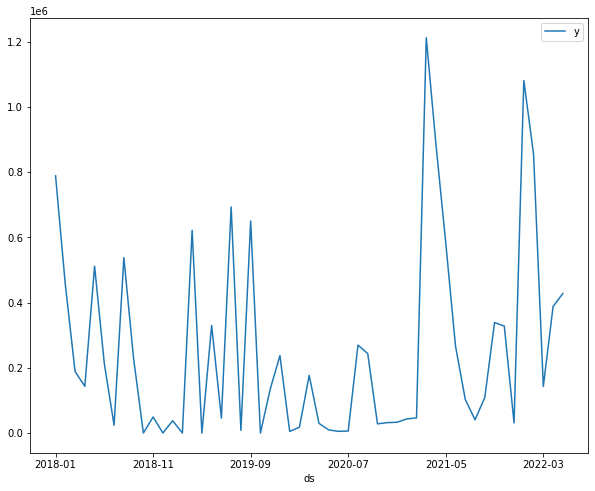

In [456]:
ax = filtered.plot(x='ds', y='y')

In [457]:
cat_part = (cat_df.repartition(spark.sparkContext.defaultParallelism, ['ds'])).cache()
cat_part.explain()

== Physical Plan ==
InMemoryTableScan [cat#15378, ds#15379, y#15380]
   +- InMemoryRelation [cat#15378, ds#15379, y#15380], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(ds#15379, 16), REPARTITION_BY_NUM, [id=#5164]
            +- *(2) Project [cat#15378, ds#15379, y#15380]
               +- *(2) Sort [cat#15378 ASC NULLS FIRST, month#15349 ASC NULLS FIRST], true, 0
                  +- Exchange rangepartitioning(cat#15378 ASC NULLS FIRST, month#15349 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#5159]
                     +- *(1) Project [category#15350 AS cat#15378, month#15349 AS ds#15379, total_price#15351 AS y#15380, month#15349]
                        +- *(1) Filter (isnotnull(month#15349) AND (month#15349 > 2018))
                           +- FileScan csv [month#15349,category#15350,total_price#15351] Batched: false, DataFilters: [isnotnull(month#15349), (month#15349 > 2018)], Format: CSV, Location: InMemoryFileIndex(1 paths)[fil

In [458]:
from pyspark.sql.types import *
result_schema = StructType([
                  StructField('ds', TimestampType()),
                  StructField('cat', StringType()),
                  StructField('y', DoubleType()),
                  StructField('yhat', DoubleType()),
                  StructField('yhat_upper', DoubleType()),
                  StructField('yhat_lower', DoubleType())
])

In [459]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from fbprophet.serialize import model_to_json, model_from_json
import json

In [460]:
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def insample_forecast(cat_pd):
    category = cat_pd['cat'].iloc[0]
    model = Prophet()
    train = cat_pd.iloc[:cat_pd.shape[0] - 12]
    model.fit(train)
    forecast_pd = model.predict(cat_pd)
    f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
    ct_pd = cat_pd[['ds', 'cat', 'y']].set_index('ds')
    result_pd = f_pd.join(ct_pd, how='left')
    result_pd.reset_index(level=0, inplace=True)
    result_pd['cat'] = category
    return result_pd[['ds', 'cat', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [461]:
from sklearn.metrics import mean_squared_error

performance_schema = StructType([
                  StructField('cat', StringType()),
                  StructField('MSE', DoubleType()),
                  StructField('RMSE', DoubleType())
])

@pandas_udf(performance_schema, PandasUDFType.GROUPED_MAP)
def performance(cat_pd):
    category = cat_pd['cat'].iloc[0]
    model = Prophet()
    train = cat_pd.iloc[:cat_pd.shape[0] - 12]
    model.fit(train)
    forecast_pd = model.predict(cat_pd)
    mse = mean_squared_error(cat_pd['y'].values, forecast_pd['yhat'].values)
    rmse = mean_squared_error(cat_pd['y'].values, forecast_pd['yhat'].values, squared=False)
    return pd.DataFrame(data={'cat': [category], 'MSE': mse, 'RMSE': rmse})

In [462]:
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_sales(cat_pd):
    category = cat_pd['cat'].iloc[0]
    model = Prophet()
    model.fit(cat_pd)
    with open(f'/tmp/models/serialized_model-{category}.json', 'w') as fout:
        json.dump(model_to_json(model), fout)  # Save model
    future_pd = model.make_future_dataframe(periods=12, freq='MS')
    forecast_pd = model.predict(future_pd)
    f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
    ct_pd = cat_pd[['ds', 'cat', 'y']].set_index('ds')
    result_pd = f_pd.join(ct_pd, how='left')
    result_pd.reset_index(level=0, inplace=True)
    result_pd['cat'] = category
    return result_pd[['ds', 'cat', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [463]:
from pyspark.sql.functions import current_date
performance = (cat_part.groupby('cat').apply(performance).withColumn('training_date', current_date()))
testing = (cat_part.groupby('cat').apply(insample_forecast).withColumn('training_date', current_date()))
results = (cat_part.groupby('cat').apply(forecast_sales).withColumn('training_date', current_date()))
results.cache()

/usr/local/spark/python/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


DataFrame[ds: timestamp, cat: string, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [464]:
performance.coalesce(1)
performance.createOrReplaceTempView('testPerformance')

testing.coalesce(1)
testing.createOrReplaceTempView('test')

results.coalesce(1)
results.createOrReplaceTempView('forecasted')

In [476]:
spark.sql("SELECT * FROM testPerformance ORDER BY MSE ASC").show(4)

+----+--------------------+------------------+-------------+
| cat|                 MSE|              RMSE|training_date|
+----+--------------------+------------------+-------------+
|1213|  3960356.0837326674|1990.0643416062373|   2022-06-12|
|0706|2.0395756438215207E7| 4516.166121636272|   2022-06-12|
|0708|4.0493632449587755E7| 6363.460729004914|   2022-06-12|
|1200| 5.254719455603309E7| 7248.944375288935|   2022-06-12|
+----+--------------------+------------------+-------------+
only showing top 4 rows



In [488]:
category = '0706'

In [489]:
spark.sql(f"SELECT * FROM test WHERE cat = '{category}'").show(4)

+-------------------+----+----+-------------------+------------------+-------------------+-------------+
|                 ds| cat|   y|               yhat|        yhat_upper|         yhat_lower|training_date|
+-------------------+----+----+-------------------+------------------+-------------------+-------------+
|2018-01-01 00:00:00|0706|null| -517.4876339886384|2543.9307897655526|-3613.2019143021257|   2022-06-12|
|2018-02-01 00:00:00|0706|null|-1906.0018470766445|1267.6574814052715| -4984.727477233596|   2022-06-12|
|2018-03-01 00:00:00|0706|null|  550.7626564281572| 3704.794238293465|-2528.9615991429782|   2022-06-12|
|2018-04-01 00:00:00|0706|null| 1197.7410313794721| 4318.324401905958| -1929.544602834549|   2022-06-12|
+-------------------+----+----+-------------------+------------------+-------------------+-------------+
only showing top 4 rows



In [490]:
spark.sql(f"SELECT * FROM forecasted WHERE cat = '{category}'").show(4)

+-------------------+----+----+-------------------+------------------+-------------------+-------------+
|                 ds| cat|   y|               yhat|        yhat_upper|         yhat_lower|training_date|
+-------------------+----+----+-------------------+------------------+-------------------+-------------+
|2018-01-01 00:00:00|0706|null|  574.7127279852509|3849.3097766127353|-2783.1384046037383|   2022-06-12|
|2018-02-01 00:00:00|0706|null|-1912.1353694167274|1263.4693201720793| -5190.870314546963|   2022-06-12|
|2018-03-01 00:00:00|0706|null| 1349.6847561890513| 4640.552018405705|-1654.4889348695056|   2022-06-12|
|2018-04-01 00:00:00|0706|null| 1407.1567290418807| 4326.009041864959|-1869.5229531674104|   2022-06-12|
+-------------------+----+----+-------------------+------------------+-------------------+-------------+
only showing top 4 rows



In [491]:
final_df = results.toPandas()
fdf_cat = final_df[final_df['cat'] == category].copy().set_index('ds')

In [492]:
pdf_cat = pdf[pdf['cat'] == category].copy()
pdf_cat['ds'] = pd.to_datetime(pdf_cat['ds'])
pdf_cat = pdf_cat.set_index('ds')

In [493]:
fdf_cat = fdf_cat.combine_first(pdf_cat).fillna(0.0)
fdf_cat['y'] = fdf_cat['y'].astype(float)

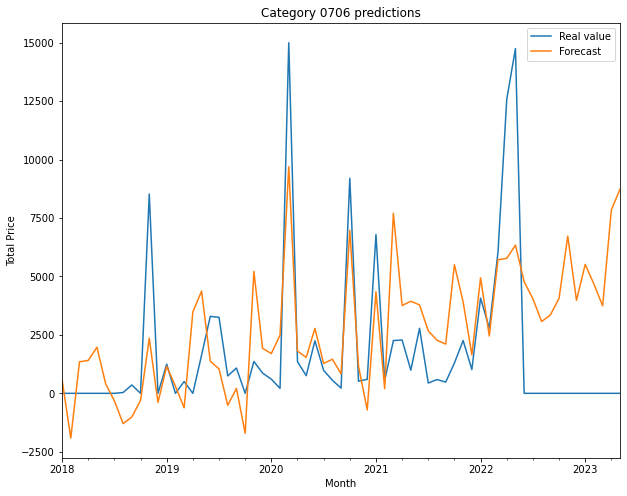

In [500]:
fig, ax = plt.subplots()
fdf_cat[['y', 'yhat']].plot(ax=ax)
plt.title(f'Category {category} predictions')
plt.ylabel('Total Price')
plt.xlabel('Month')
ax.legend(["Real value", "Forecast"]);
plt.show()